In [ ]:
# RUN ONCE

import kagglehub

# Download latest version
path = kagglehub.dataset_download("debashishsau/aslamerican-sign-language-aplhabet-dataset")

print("Path to dataset files:", path)

# move the dataset to a new location

import shutil
shutil.move(path, "debashishsau_dataset")

100%|██████████| 4.20G/4.20G [06:10<00:00, 12.2MB/s]

Extracting files...


Path to dataset files: C:\Users\Mahyar\.cache\kagglehub\datasets\debashishsau\aslamerican-sign-language-aplhabet-dataset\versions\1


In [ ]:
# make sure you have CUDA available
import torch
print("CUDA available:", torch.cuda.is_available())
print(f"PyTorch CUDA version: {torch.version.cuda}")
print(f"PyTorch built with CUDA: {torch.version.cuda}")

CUDA available: True
PyTorch CUDA version: 12.4
PyTorch built with CUDA: 12.4


In [ ]:
### NOTICE 
# 1. clone https://github.com/guglielmocamporese/hands-segmentation-pytorch 
# 2. run ./scripts/download_model_checkpoint.sh from hands directory in bash. Make sure to have the conda environment activated, with gdown installed.
# if you don't do this, you'll get a bunch of blank images.

# !python hands/main.py --mode predict --data_base_path debashishsau_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/A --model_checkpoint "hands/checkpoint/checkpoint.ckpt" --model_pretrained

### NOW YOU MUST SEGMENT THE DATA USING THE HANDS MODEL AND SAVE THE SEGMENTED DATA TO A NEW LOCATION.
# now loop this for every letter
import os
from tqdm import tqdm

for letter in tqdm(os.listdir("debashishsau_dataset/ASL_Alphabet_Dataset/asl_alphabet_train")):
    path = os.path.join("debashishsau_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/", letter)
    !python hands/main.py --mode predict --data_base_path $path --model_checkpoint "hands/checkpoint/checkpoint.ckpt" --model_pretrained

In [ ]:
# take the regular data and the segmented data, and make overlap so that the pixels that are white in the segmented data are kept as normal in the regular data.
# and the pixels that are black in the segmented data are set to black in the regular data.
# note that the regular data is for ex xxx.jpg, and the segmented data is for ex xxx_pred.png, in the same location.

import os
import cv2
import numpy as np

def overlap_images(data_path, segmented_path, output_path):
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith(".jpg"):
                file_name = file.replace(".jpg", "")
                img = cv2.imread(os.path.join(root, file))
                seg = cv2.imread(os.path.join(segmented_path, file_name + "-pred.png"))
              
                # cv2.imshow('Result', seg)
                # cv2.waitKey(0)
                # cv2.destroyAllWindows()
                mask = np.all(seg == 0, axis=-1)
                
                processed_img = img.copy()
                processed_img[mask] = [0,0,0]
                
                # if output dir doesn't exist yet, create it
                if not os.path.exists(output_path):
                    os.makedirs(output_path)
                    
                    
                cv2.imwrite(os.path.join(output_path, file), processed_img)
                
               
               
data_path = "debashishsau_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/" 
for letter in os.listdir(data_path):
    overlap_images(os.path.join(data_path, letter), os.path.join(data_path, letter), os.path.join(data_path, letter + "_processed"))

In [4]:
# move the processed data to a new location, only move folders that end with _processed

import shutil
data_path = "debashishsau_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/"
for letter in os.listdir(data_path):
    if letter.endswith("_processed"):
        shutil.move(os.path.join(data_path, letter), "debashishsau_dataset_processed")



In [8]:
# split into training and validation
import os
import shutil
import random

data_path = "debashishsau_dataset_processed"
train_path = "debashishsau_dataset_processed_train"
val_path = "debashishsau_dataset_processed_val"

if not os.path.exists(train_path):
    os.makedirs(train_path)
if not os.path.exists(val_path):
    os.makedirs(val_path)
    
for letter in os.listdir(data_path):
    if not letter.startswith("."):
        files = os.listdir(os.path.join(data_path, letter))
        random.shuffle(files)
        split = int(0.8 * len(files))
        train_files = files[:split]
        val_files = files[split:]
        
        for file in train_files:
            if not os.path.exists(os.path.join(train_path, letter)):
                os.makedirs(os.path.join(train_path, letter))
            shutil.move(os.path.join(data_path, letter, file), os.path.join(train_path, letter, file))
        for file in val_files:
            if not os.path.exists(os.path.join(val_path, letter)):
                os.makedirs(os.path.join(val_path, letter))
            shutil.move(os.path.join(data_path, letter, file), os.path.join(val_path, letter, file))

In [ ]:
# delete useless images that are more than 90% black

import os
import cv2
import numpy as np

data_dir = "debashishsau_dataset_processed_train"
# data_dir = "debashishsau_dataset_processed_val" # then delete from val

# if image is more than 90% black, useless

useless = 0
total = 0
for letter in os.listdir(data_dir):
    for file in os.listdir(os.path.join(data_dir, letter)):
        # if file is a nothing instance, skip
        if letter == "nothing_processed":
            continue
        img = cv2.imread(os.path.join(data_dir, letter, file), cv2.IMREAD_GRAYSCALE)
        total += 1
         # Calculate the total number of pixels
        total_pixels = img.size

        # Count the number of black pixels (intensity value of 0)
        black_pixels = np.sum(img == 0)

        # Calculate the percentage of black pixels
        black_percentage = (black_pixels / total_pixels) * 100

        if black_percentage > 90:
            # # 1/200 chance of showing image
            # if np.random.randint(0, 200) == 0:
            #     cv2.imshow('Result', img)
            #     cv2.waitKey(0)
            #     cv2.destroyAllWindows()
            useless += 1
            os.remove(os.path.join(data_dir, letter, file)) # uncomment to delete
        
print(f"Useless images removed: {useless}")
print(f"Total images: {total}")
print(f"Percentage useless: {useless / total * 100}%")


NotADirectoryError: [WinError 267] The directory name is invalid: 'test_processed\\A22_jpg.rf.f02ad8558ce1c88213b4f83c0bc66bc8.jpg'

In [19]:
specific_file_path= "debashishsau_dataset_processed_val\E_processed\E (77).jpg"

# test black % of this image
img = cv2.imread(specific_file_path, cv2.IMREAD_GRAYSCALE)
total_pixels = img.size
black_pixels = np.sum(img == 0)
black_percentage = (black_pixels / total_pixels) * 100
print(f"Black percentage of {specific_file_path}: {black_percentage}")


Black percentage of debashishsau_dataset_processed_val\E_processed\E (77).jpg: 91.58500000000001


<>:1: SyntaxWarning: invalid escape sequence '\E'
<>:1: SyntaxWarning: invalid escape sequence '\E'
C:\Users\Mahyar\AppData\Local\Temp\ipykernel_26212\923189695.py:1: SyntaxWarning: invalid escape sequence '\E'
  specific_file_path= "debashishsau_dataset_processed_val\E_processed\E (77).jpg"


c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


512
Epoch 0/21
----------
train Loss: 1.3549 Acc: 0.6107
val Loss: 0.2185 Acc: 0.9387

Epoch 1/21
----------
train Loss: 0.8054 Acc: 0.7736
val Loss: 0.1487 Acc: 0.9598

Epoch 2/21
----------
train Loss: 0.6819 Acc: 0.8096
val Loss: 0.1139 Acc: 0.9699

Epoch 3/21
----------
train Loss: 0.6079 Acc: 0.8310
val Loss: 0.1027 Acc: 0.9765

Epoch 4/21
----------
train Loss: 0.5673 Acc: 0.8430
val Loss: 0.0961 Acc: 0.9804

Epoch 5/21
----------
train Loss: 0.5330 Acc: 0.8526
val Loss: 0.0733 Acc: 0.9825

Epoch 6/21
----------
train Loss: 0.5104 Acc: 0.8603
val Loss: 0.0784 Acc: 0.9840

Epoch 7/21
----------
train Loss: 0.4196 Acc: 0.8858
val Loss: 0.0484 Acc: 0.9915

Epoch 8/21
----------
train Loss: 0.3933 Acc: 0.8939
val Loss: 0.0488 Acc: 0.9917

Epoch 9/21
----------
train Loss: 0.3802 Acc: 0.8970
val Loss: 0.0490 Acc: 0.9932

Epoch 10/21
----------
train Loss: 0.3756 Acc: 0.8982
val Loss: 0.0433 Acc: 0.9931

Epoch 11/21
----------
train Loss: 0.3640 Acc: 0.9019
val Loss: 0.0447 Acc: 0.9938

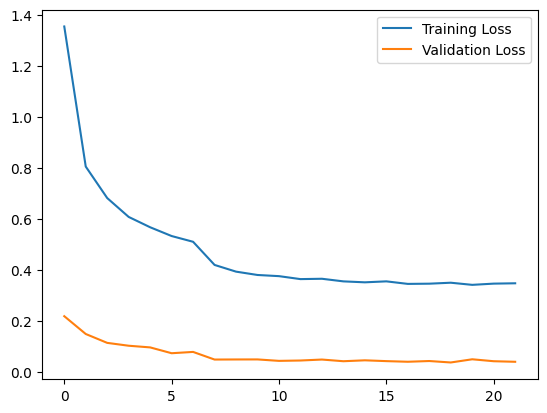

In [ ]:
# By this stage your preprocessed data should be ready for training in the folder 
# debashishsau_dataset_processed_train and debashishsau_dataset_processed_val

# transfer learing from resnet18, 512 to one layer of 256 neurons, to 128, and then 29 neurons for the 29 classes

import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import time
import os

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = "debashishsau_dataset_processed"

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir + '_' + x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

training_losses = []
validation_losses = []


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                training_losses.append(epoch_loss)
            else:
                validation_losses.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
print(num_ftrs)

# 512 -> 256 -> 128 -> 29

model_ft.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 29),
)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                          num_epochs=22)



# save the model
torch.save(model_ft, "asl_model_256_128.pth")

# show plot of training and validation loss
import matplotlib.pyplot as plt

#save plot to file
plt.plot(training_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.legend()
plt.savefig("loss_plot.png")
plt.show()

(1920, 1920)


In [ ]:
# segment the test data
# remember test folder is flat, no subfolders
# this is just random data I got from the internet

import os

test_dir = "roboflow_test" # for roboflow
# test_dir = "misc_test"  # for misc
 
for file in os.listdir(test_dir):
    if file.endswith(".jpg"):
        !python hands/main.py --mode predict --data_base_path $test_dir --model_checkpoint "hands/checkpoint/checkpoint.ckpt" --model_pretrained
            


{
    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "roboflow_test",
    "model_pretrained": true,
    "model_checkpoint": "hands/checkpoint/checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}
Loaded checkpoint from hands/checkpoint/checkpoint.ckpt.
model built
Found 1513 in roboflow_test.


c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\U

{
    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "roboflow_test",
    "model_pretrained": true,
    "model_checkpoint": "hands/checkpoint/checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}
Loaded checkpoint from hands/checkpoint/checkpoint.ckpt.
model built
Found 1512 in roboflow_test.


c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\U

{
    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "roboflow_test",
    "model_pretrained": true,
    "model_checkpoint": "hands/checkpoint/checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}
Loaded checkpoint from hands/checkpoint/checkpoint.ckpt.
model built
Found 1512 in roboflow_test.


c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\U

{

c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\U


    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "roboflow_test",
    "model_pretrained": true,
    "model_checkpoint": "hands/checkpoint/checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}
Loaded checkpoint from hands/checkpoint/checkpoint.ckpt.
model built
Found 1512 in roboflow_test.
{
    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "roboflow_test",
    "model_pretrained": true,
    "model_checkpoint": "hands/checkpoint/checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}
Loaded checkpoint from hands/checkpoint/checkpoint.ckpt.
model built
Found 1512 in roboflow_test.


c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\U

{

c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\U


    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "roboflow_test",
    "model_pretrained": true,
    "model_checkpoint": "hands/checkpoint/checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}
Loaded checkpoint from hands/checkpoint/checkpoint.ckpt.
model built
Found 1512 in roboflow_test.
{
    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "roboflow_test",
    "model_pretrained": true,
    "model_checkpoint": "hands/checkpoint/checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}
Loaded checkpoint from hands/checkpoint/checkpoint.ckpt.
model built
Found 1512 in roboflow_test.


c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\U

{
    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "roboflow_test",
    "model_pretrained": true,
    "model_checkpoint": "hands/checkpoint/checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}
Loaded checkpoint from hands/checkpoint/checkpoint.ckpt.
model built
Found 1512 in roboflow_test.


c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\U

{
    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "roboflow_test",
    "model_pretrained": true,
    "model_checkpoint": "hands/checkpoint/checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}
Loaded checkpoint from hands/checkpoint/checkpoint.ckpt.
model built
Found 1512 in roboflow_test.


c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\U

{
    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "roboflow_test",
    "model_pretrained": true,
    "model_checkpoint": "hands/checkpoint/checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}
Loaded checkpoint from hands/checkpoint/checkpoint.ckpt.
model built
Found 1512 in roboflow_test.


c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\U

{

c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\U


    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "roboflow_test",
    "model_pretrained": true,
    "model_checkpoint": "hands/checkpoint/checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}
Loaded checkpoint from hands/checkpoint/checkpoint.ckpt.
model built
Found 1512 in roboflow_test.
{
    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "roboflow_test",
    "model_pretrained": true,
    "model_checkpoint": "hands/checkpoint/checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}
Loaded checkpoint from hands/checkpoint/checkpoint.ckpt.
model built
Found 1512 in roboflow_test.


c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\U

{
    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "roboflow_test",
    "model_pretrained": true,
    "model_checkpoint": "hands/checkpoint/checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}
Loaded checkpoint from hands/checkpoint/checkpoint.ckpt.
model built
Found 1512 in roboflow_test.


c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\U

{
    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "roboflow_test",
    "model_pretrained": true,
    "model_checkpoint": "hands/checkpoint/checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}
Loaded checkpoint from hands/checkpoint/checkpoint.ckpt.
model built
Found 1512 in roboflow_test.


c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\U

{
    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "roboflow_test",
    "model_pretrained": true,
    "model_checkpoint": "hands/checkpoint/checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}
Loaded checkpoint from hands/checkpoint/checkpoint.ckpt.
model built
Found 1512 in roboflow_test.


c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\U

{
    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "roboflow_test",
    "model_pretrained": true,
    "model_checkpoint": "hands/checkpoint/checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}
Loaded checkpoint from hands/checkpoint/checkpoint.ckpt.
model built
Found 1512 in roboflow_test.


c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\U

{
    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "roboflow_test",
    "model_pretrained": true,
    "model_checkpoint": "hands/checkpoint/checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}
Loaded checkpoint from hands/checkpoint/checkpoint.ckpt.
model built
Found 1512 in roboflow_test.


c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\U

{
    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "roboflow_test",
    "model_pretrained": true,
    "model_checkpoint": "hands/checkpoint/checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}
Loaded checkpoint from hands/checkpoint/checkpoint.ckpt.
model built
Found 1512 in roboflow_test.


c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\U

{
    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "roboflow_test",
    "model_pretrained": true,
    "model_checkpoint": "hands/checkpoint/checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}
Loaded checkpoint from hands/checkpoint/checkpoint.ckpt.
model built
Found 1512 in roboflow_test.


c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\U

{

c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\U


    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "roboflow_test",
    "model_pretrained": true,
    "model_checkpoint": "hands/checkpoint/checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}
Loaded checkpoint from hands/checkpoint/checkpoint.ckpt.
model built
Found 1512 in roboflow_test.
{
    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "roboflow_test",
    "model_pretrained": true,
    "model_checkpoint": "hands/checkpoint/checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}
Loaded checkpoint from hands/checkpoint/checkpoint.ckpt.
model built
Found 1512 in roboflow_test.


c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\U

{
    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "roboflow_test",
    "model_pretrained": true,
    "model_checkpoint": "hands/checkpoint/checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}
Loaded checkpoint from hands/checkpoint/checkpoint.ckpt.
model built
Found 1512 in roboflow_test.


c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\U

^C
{
    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "roboflow_test",
    "model_pretrained": true,
    "model_checkpoint": "hands/checkpoint/checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}
Loaded checkpoint from hands/checkpoint/checkpoint.ckpt.
model built
Found 1512 in roboflow_test.


c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\Mahyar\anaconda3\envs\signitup\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\U

In [1]:
# overlap images in test that end in -pred.png with the original images
import os
import cv2
import numpy as np

def overlap_images(data_path, segmented_path, output_path):
    # files are flat in test dir
    
    for file in os.listdir(data_path):
        if file.endswith(".jpg"):
            file_name = file.replace(".jpg", "")
            img = cv2.imread(os.path.join(data_path, file))
            seg = cv2.imread(os.path.join(segmented_path, file_name + "-pred.png"))
            # cv2.imshow('Result', seg)
            # cv2.waitKey(0)
            # cv2.destroyAllWindows()
            mask = np.all(seg == 0, axis=-1)

            processed_img = img.copy()
            processed_img[mask] = [0,0,0]

            # if output dir doesn't exist yet, create it
            if not os.path.exists(output_path):
                os.makedirs(output_path)


            cv2.imwrite(os.path.join(output_path, file), processed_img)
            
test_dir = "roboflow_test"
# test_dir = "misc_test"
overlap_images(test_dir, test_dir, "test_processed")

In [4]:
# remove images that are more than 90% black
import os
import cv2
import numpy as np

data_dir = "test_processed"

useless = 0
total = 0

for file in os.listdir(data_dir):
    img = cv2.imread(os.path.join(data_dir, file), cv2.IMREAD_GRAYSCALE)
    total += 1
     # Calculate the total number of pixels
    total_pixels = img.size

    # Count the number of black pixels (intensity value of 0)
    black_pixels = np.sum(img == 0)

    # Calculate the percentage of black pixels
    black_percentage = (black_pixels / total_pixels) * 100

    if black_percentage > 90:
        # # 1/200 chance of showing image
        # if np.random.randint(0, 200) == 0:
        #     cv2.imshow('Result', img)
        #     cv2.waitKey(0)
        #     cv2.destroyAllWindows()
        useless += 1
        os.remove(os.path.join(data_dir, file)) # uncomment to delete
        
print(f"Useless images removed: {useless}")
print(f"Total images: {total}")
print(f"Percentage useless: {useless / total * 100}%")


Useless images removed: 341
Total images: 1512
Percentage useless: 22.552910052910054%


In [16]:
# test the images in the test_data_processed folder

import torch
import torchvision.transforms as transforms
from PIL import Image
import os
import cv2
import numpy as np

model = torch.load("models/asl_model_256.pth")
model.eval()

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_path = "test_processed"
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
correct = 0
total = 0
for file in os.listdir(data_path):
    img = Image.open(os.path.join(data_path, file))
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = transform(img)
    img = img.unsqueeze(0)
    output = model(img.cuda())
    _, pred = torch.max(output, 1)
    
    # get the letter from the file name
    letter = file[0]
    
    if class_names[pred] == letter:
        correct += 1
    
    # show image with prediction in image
    # if (letter == 'D'):
    #     img = cv2.imread(os.path.join(data_path, file))
    #     cv2.putText(img, 'pred ' + class_names[pred], (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    #     cv2.putText(img, 'actual ' + letter, (200, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    #     cv2.imshow('Result', img)
    #     cv2.waitKey(0)
    #     cv2.destroyAllWindows()
        
    total += 1
    
print(f"Accuracy: {correct / total * 100}%")
    
    
    # cv2.imshow('Result', cv2.imread(os.path.join(data_path, file)))
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    

C:\Users\Mahyar\AppData\Local\Temp\ipykernel_45900\158955478.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("models/asl_model_256.pth")


Accuracy: 42.44235695986337%


In [7]:
# test the model
# show webcam feed and predict the sign language letter

import cv2
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
import subprocess
import os

model = torch.load("models/asl_model_256.pth")
model.eval()

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
    img = Image.fromarray(frame)
    img = transform(img)    
    img = img.unsqueeze(0)
    
    # persist to webcam folder
    cv2.imwrite("webcam/webcam.jpg", frame)
    
    result = subprocess.run(
        ["python", "./hands/main.py", "--mode", "predict", "--data_base_path", "webcam", "--model_checkpoint", "hands/checkpoint/checkpoint.ckpt", "--model_pretrained"],  # Command to run the script,
        text=True,               # Ensures the output is captured as a string
        capture_output=True,      # Captures stdout and stderr
    )

    segmented_img_data = result.stdout
    data_path = "webcam"

    # overlap segmented webcam with original webcam
    for file in os.listdir(data_path):
        if file.endswith(".jpg"):
            file_name = file.replace(".jpg", "")
            img = cv2.imread(os.path.join(data_path, file))
            
            # cv2.imshow('Result', seg)
            # cv2.waitKey(0)
            # cv2.destroyAllWindows()
            mask = np.all(segmented_img_data == 0, axis=-1)

            processed_img = img.copy()
            processed_img[mask] = [0,0,0]
    
    processed_img = Image.fromarray(processed_img)
    processed_img = transform(processed_img)
    processed_img = processed_img.unsqueeze(0)
 
    with torch.no_grad():
        outputs = model(processed_img.cuda())
        _, preds = torch.max(outputs, 1)
        print(class_names[preds.item()])
        
        cv2.putText(frame, class_names[preds.item()], (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
        cv2.imshow('Result', frame)
        
        
        
cap.release()
cv2.destroyAllWindows()



    

C:\Users\Mahyar\AppData\Local\Temp\ipykernel_33384\3508643111.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("models/asl_model_256.pth")


F
H
H
Z
A
Z
Z
A


: 

In [ ]:
# # delete any files in this dir that have the word 'pred' in them

import os
for filename in os.listdir('roboflow_test'):
    if 'pred' in filename:
        os.remove(f'roboflow_test/{filename}')
    